# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Final Project Group 40: Trump Tweets and Market Volatility


**Harvard University**<br/>
**Fall 2019**<br/>
**Group**: Dylan DeMarco, Daiki Ina, Roger Zhang, Jerry Huang

<hr style="height:2pt">

In [340]:
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import pandas_profiling

/Users/dylandemarco/PSets/Venvs/CS109Venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dylandemarco/PSets/Venvs/CS109Venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/dylandemarco/PSets/Venvs/CS109Venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

1.2930574838486388 -0.02588313413014608


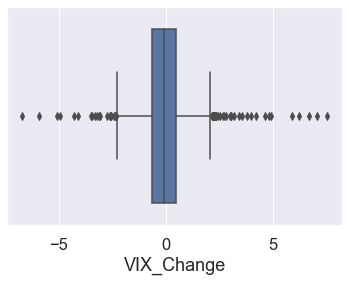

In [470]:
vix_df = pd.read_csv('./data/raw/vix_data.csv', index_col=0)
vix_df.Date = pd.to_datetime(vix_df.Date)
# We only use Open in our models
vix_df.drop(columns=['VIX High', 'VIX Low', 'VIX Close'], inplace=True)
vix_df['VIX_Change'] = vix_df['VIX Open'].diff()
vix_df.VIX_Change[vix_df['VIX_Change'] > 10] = 7.5
vix_df['VIX_change_type'] = 0

q33 = vix_df.VIX_Change.quantile(.33)
q67 = vix_df.VIX_Change.quantile(.67)
std = vix_df.VIX_Change.std()
mean = vix_df.VIX_Change.mean()
print(std, mean)
window = 0.5

vix_df.VIX_change_type[vix_df['VIX_Change'] > (mean + (window * std)) ] = 1
vix_df.VIX_change_type[vix_df['VIX_Change'] < (mean - (window * std)) ] = -1

sns.boxplot(vix_df.VIX_Change[1:-1])

vix_df.groupby('VIX_change_type').count()
# Drop enough days to use DOW even in models where we don't need it for fair comparison
vix_df.drop(columns=['VIX Open', 'VIX_Change'], inplace=True)
vix_df = vix_df.loc[vix_df.Date > '2016-11-16']

In [471]:
tweet_df_raw = pd.read_csv('./data/raw/reference_date_5.csv', index_col=0)
tweet_df_full = tweet_df_raw.drop(columns="Unnamed: 0.1")
tweet_df_full.ref_date = pd.to_datetime(tweet_df_full.ref_date)

# splits into filtered (Trump only) and unflitered dfs
tweet_df_filtered = tweet_df_full[tweet_df_full['trump_classification_binary'] == 1]

econ_tweets = tweet_df_filtered[tweet_df_filtered.word_mentions > 0]

In [472]:
# Group tweets
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
grouped_tweets_full = tweet_df_full.groupby('ref_date').agg({
                                                'polarity':['mean', 'max', 'min'], 
                                                'word_mentions':'sum',
                                                'dot':'sum',
                                                'DT': 'count'})
grouped_tweets_filtered = tweet_df_filtered.groupby('ref_date').agg({
                                                    'polarity':['mean', 'max', 'min'], 
                                                    'word_mentions':'sum',
                                                    'dot':'sum',
                                                    'DT': 'count'})

grouped_tweets_econ = econ_tweets.groupby('ref_date').agg({
                                                    'polarity':['mean', 'max', 'min'], 
                                                    'word_mentions':'sum',
                                                    'dot':'sum',
                                                    'DT': 'count'})



grouped_tweets_full.head(3)

polarity              word_mentions dot    DT
                mean    max   min           sum sum count
ref_date                                                 
2016-11-10  0.450000  0.450  0.45             0   0     1
2016-11-11  0.399875  1.000  0.00             0   0     5
2016-11-14  0.345950  0.925 -0.70             0   0    10

In [473]:
dow_df = pd.read_csv('./data/raw/dow_range_past5days_data.csv')
dow_df.Date = pd.to_datetime(dow_df.Date)
dow_df.set_index("Date", inplace=True)
dow_df.head(3)

,dow_d_min_1,dow_d_min_2,dow_d_min_3,dow_d_min_4,dow_d_min_5
Date,,,,,
2016-11-17,83.958984,119.199219,118.300781,118.818359,270.519531
2016-11-18,58.759766,83.958984,119.199219,118.300781,118.818359
2016-11-21,61.910156,58.759766,83.958984,119.199219,118.300781


In [474]:
model_df_full = vix_df.join(grouped_tweets_full, how="left", on="Date")
model_df_full = model_df_full.join(dow_df, how="left", on="Date")
# Inpute with zero because we decide conservatively to disregard the effects of the previous day
# There are only 15 days with no tweets
model_df_full.fillna(0, inplace=True)

# model_df[('polarity', 'mean')]
model_df_filtered = vix_df.join(grouped_tweets_filtered, how="left", on="Date")
model_df_filtered = model_df_filtered.join(dow_df, how="left", on="Date")
# Inpute with zero because we decide conservatively to disregard the effects of the previous day
# There are only 15 days with no tweets
model_df_filtered.fillna(0, inplace=True)

# model_df[('polarity', 'mean')]
model_df_econ = vix_df.join(grouped_tweets_econ, how="left", on="Date")
model_df_econ = model_df_econ.join(dow_df, how="left", on="Date")
# Inpute with zero because we decide conservatively to disregard the effects of the previous day
# There are only 15 days with no tweets
model_df_econ.fillna(0, inplace=True)


display(model_df_full.describe())
display(model_df_filtered.describe())

/Users/dylandemarco/PSets/Venvs/CS109Venv/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,VIX_change_type,"(polarity, mean)","(polarity, max)","(polarity, min)","(word_mentions, sum)","(dot, sum)","(DT, count)",dow_d_min_1,dow_d_min_2,dow_d_min_3,dow_d_min_4,dow_d_min_5
count,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,-0.028075,0.165556,0.698768,-0.301010,2.733957,2.434492,12.052139,216.653062,216.654344,216.669708,216.674118,216.762406
std,0.667079,0.141405,0.293777,0.309617,3.914422,3.409136,9.562797,175.734729,175.734014,175.724899,175.722399,175.732854
min,-1.000000,-0.330556,0.000000,-1.000000,0.000000,0.000000,0.000000,35.089844,35.089844,35.089844,35.089844,35.089844
25%,0.000000,0.075188,0.500000,-0.500000,0.000000,0.000000,6.000000,104.114747,104.114747,104.114747,104.114747,104.114747
50%,0.000000,0.150982,0.750000,-0.272140,2.000000,1.000000,10.000000,161.009765,161.009765,161.009765,161.009765,161.009765
75%,0.000000,0.234790,1.000000,-0.065427,4.000000,3.000000,16.000000,273.887696,273.887696,273.887696,273.887696,273.887696
max,1.000000,0.966667,1.000000,0.900000,46.000000,20.000000,71.000000,1596.648438,1596.648438,1596.648438,1596.648438,1596.648438


,VIX_change_type,"(polarity, mean)","(polarity, max)","(polarity, min)","(word_mentions, sum)","(dot, sum)","(DT, count)",dow_d_min_1,dow_d_min_2,dow_d_min_3,dow_d_min_4,dow_d_min_5
count,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,-0.028075,0.112089,0.477359,-0.250017,2.213904,2.132353,7.871658,216.653062,216.654344,216.669708,216.674118,216.762406
std,0.667079,0.165232,0.289554,0.316646,3.304651,3.151230,6.867232,175.734729,175.734014,175.724899,175.722399,175.732854
min,-1.000000,-0.575000,-0.575000,-1.000000,0.000000,0.000000,0.000000,35.089844,35.089844,35.089844,35.089844,35.089844
25%,0.000000,0.002310,0.297074,-0.437500,0.000000,0.000000,3.000000,104.114747,104.114747,104.114747,104.114747,104.114747
50%,0.000000,0.100590,0.500000,-0.237240,1.000000,1.000000,6.000000,161.009765,161.009765,161.009765,161.009765,161.009765
75%,0.000000,0.196186,0.650000,0.000000,3.000000,3.000000,10.000000,273.887696,273.887696,273.887696,273.887696,273.887696
max,1.000000,1.000000,1.000000,1.000000,35.000000,18.000000,44.000000,1596.648438,1596.648438,1596.648438,1596.648438,1596.648438


In [475]:
model_df_full.to_csv('./data/model_df_full.csv')
model_df_filtered.to_csv('./data/model_df_filtered.csv')

### Base Model

RF: Base Accuracy, Training Set 	 : 54.30%
RF: Base Accuracy, Testing Set 	 : 58.22%


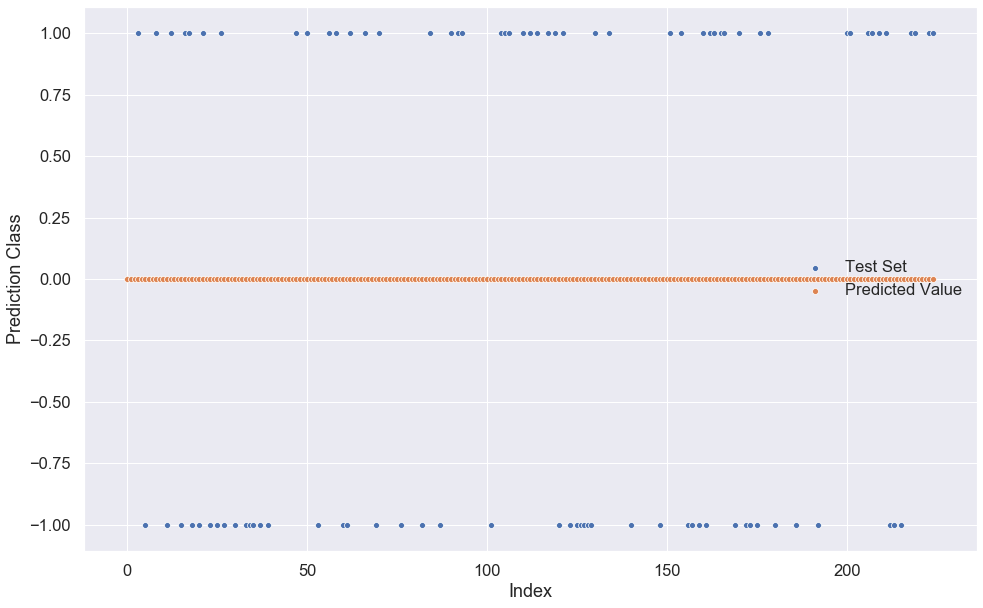

In [476]:
# average model tweet model
## basic model fitting
bm_train, bm_test = train_test_split(model_df_full, train_size=0.7, random_state=42)

train_mode = bm_train['VIX_change_type'].mode()[0]

# Split Data into X,Y
X_train, y_train = (np.ones(bm_train.shape[0]) * train_mode).reshape(-1,1), bm_train['VIX_change_type']
X_test, y_test = (np.ones(bm_test.shape[0]) * train_mode).reshape(-1,1), bm_test['VIX_change_type']

model = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
acc_trees_training = accuracy_score(y_train, y_pred_train)
acc_trees_testing  = accuracy_score(y_test, y_pred_test)

# These are changing with each fit, plus we want a more validated choice for depth, so do that
print("RF: Base Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("RF: Base Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

fig, ax = plt.subplots(1,1, figsize=(16, 10))
x = np.arange(0,y_test.shape[0],1)
sns.set(font_scale=1.5)
sns.scatterplot(x ,y_test, label = 'Test Set')
sns.scatterplot(x ,y_pred_test, label = 'Predicted Value')
plt.xlabel('Index')
plt.ylabel("Prediction Class")
plt.legend(loc="center right")
plt.show()

### Num Tweets

### Num Tweets (Filtered)

In [477]:
skip_predictors = ['VIX_change_type', 'Date', ('DT', 'count'), ('dot', 'count')]
dow_predictors = ['dow_d_min_1','dow_d_min_2', 'dow_d_min_3', 'dow_d_min_4', 'dow_d_min_5']
simple_dow = ['dow_d_min_1']
aug_dow = ['dow_d_min_2', 'dow_d_min_3', 'dow_d_min_4', 'dow_d_min_5']
trump_predictors = [('polarity', 'max'), ('polarity', 'mean'), ('polarity', 'min'), ('subjectivity', 'max'), ('subjectivity', 'mean'), ('subjectivity', 'min'), ('word_mentions', 'sum')]

### Granular Tweet

RF: Accuracy, Training Set 	 : 99.43%
RF: Accuracy, Testing Set 	 : 49.33%


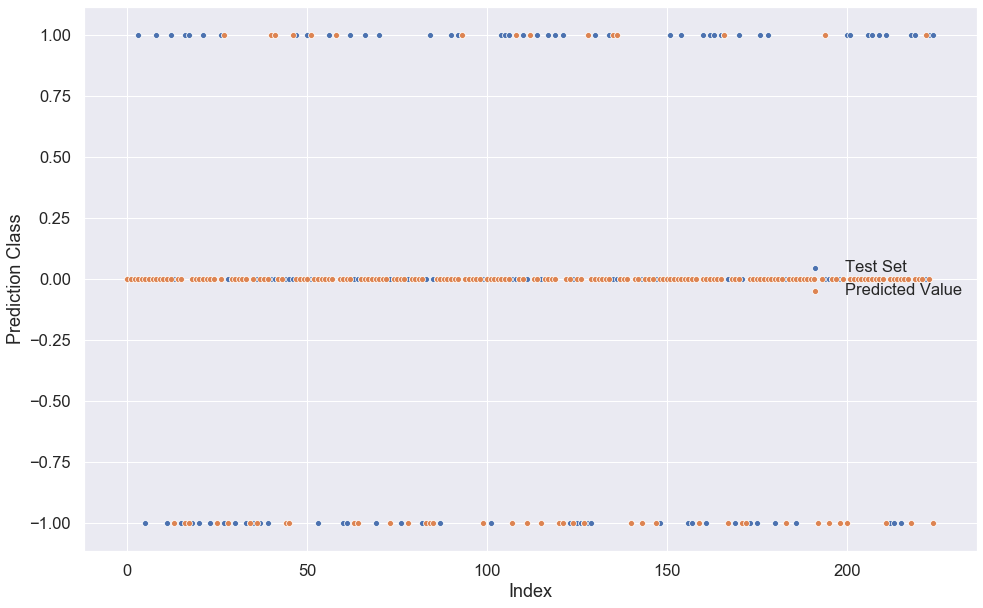

In [478]:
# average model tweet model
## basic model fitting
gt_train, gt_test = train_test_split(model_df_full, train_size=0.7, random_state=42)

# Split Data into X,Y
X_train, y_train = gt_train[gt_train.columns.difference(skip_predictors + dow_predictors )], gt_train['VIX_change_type']
X_test, y_test = gt_test[gt_test.columns.difference(skip_predictors + dow_predictors )], gt_test['VIX_change_type']

model = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
acc_trees_training = accuracy_score(y_train, y_pred_train)
acc_trees_testing  = accuracy_score(y_test, y_pred_test)

# These are changing with each fit, plus we want a more validated choice for depth, so do that
print("RF: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("RF: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

# x = np.arange(0,y_test.shape[0],1)
# sns.set(font_scale=1.5)
# sns.lineplot(x ,y_test, label = 'Test Set')
# sns.lineplot(x ,y_pred_test, label = 'Predicted Value')
# plt.xlabel('Index')
# plt.show()
fig, ax = plt.subplots(1,1, figsize=(16, 10))
x = np.arange(0,y_test.shape[0],1)
sns.set(font_scale=1.5)
sns.scatterplot(x ,y_test, label = 'Test Set')
sns.scatterplot(x ,y_pred_test, label = 'Predicted Value')
plt.xlabel('Index')
plt.ylabel("Prediction Class")
plt.legend(loc="center right")
plt.show()

### Granular Tweet (Filtered)

RF: Accuracy, Training Set 	 : 100.00%
RF: Accuracy, Testing Set 	 : 59.56%
[0.04641448 0.08670836 0.10646705 0.08700444 0.05017201 0.15405403
 0.11805639 0.12177488 0.13180715 0.09754121]


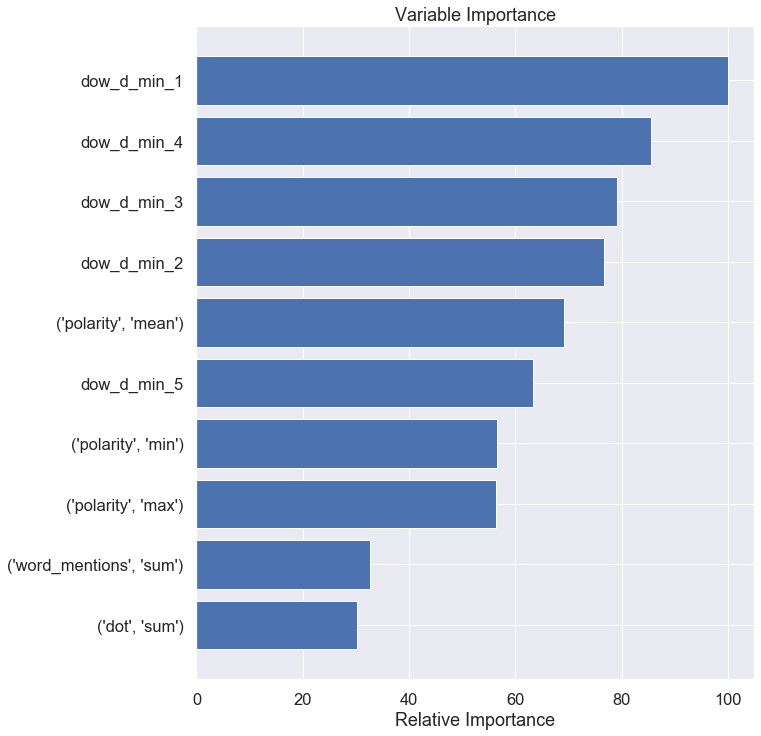

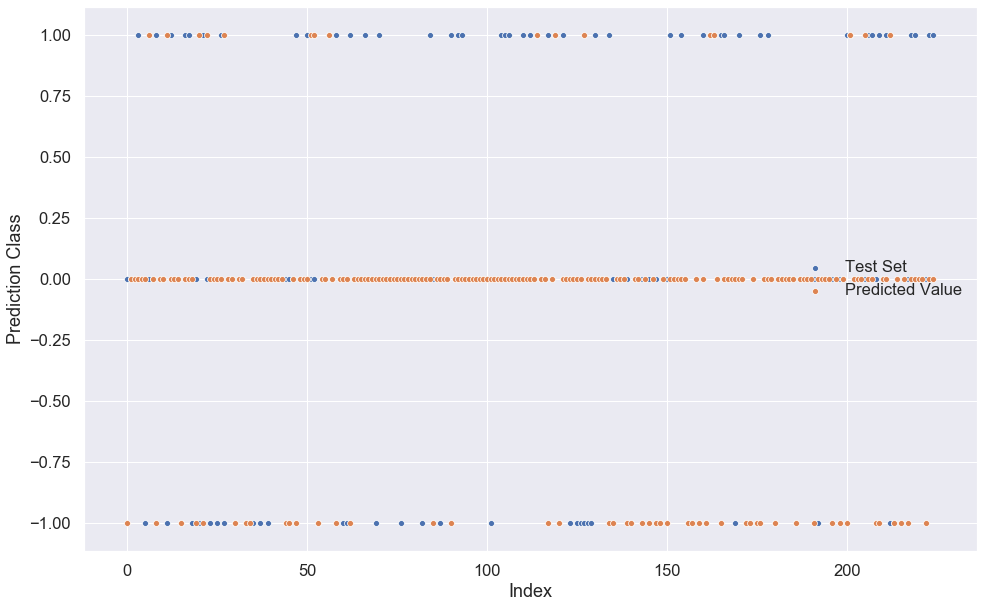

In [483]:

# average model tweet model
## basic model fitting
gtf_train, gtf_test = train_test_split(model_df_filtered, train_size=0.7, random_state=42)

# Split Data into X,Y
X_train, y_train = gtf_train[gtf_train.columns.difference(skip_predictors )], gtf_train['VIX_change_type']
X_test, y_test = gtf_test[gtf_test.columns.difference(skip_predictors  )], gtf_test['VIX_change_type']

model = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
acc_trees_training = accuracy_score(y_train, y_pred_train)
acc_trees_testing  = accuracy_score(y_test, y_pred_test)

# These are changing with each fit, plus we want a more validated choice for depth, so do that
print("RF: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("RF: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

print(model.feature_importances_)

# x = np.arange(0,y_test.shape[0],1)
# sns.set(font_scale=1.5)
# sns.lineplot(x ,y_test, label = 'Test Set')
# sns.lineplot(x ,y_pred_test, label = 'Predicted Value')
# plt.xlabel('Index')
# plt.show()

#Top Features
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

pd.crosstab(y_test, model.predict(X_test), margins=True, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(1,1, figsize=(16, 10))
x = np.arange(0,y_test.shape[0],1)
sns.set(font_scale=1.5)
sns.scatterplot(x ,y_test, label = 'Test Set')
sns.scatterplot(x ,y_pred_test, label = 'Predicted Value')
plt.xlabel('Index')
plt.ylabel("Prediction Class")
plt.legend(loc="center right")
plt.show()

RF: Accuracy, Training Set 	 : 100.00%
RF: Accuracy, Testing Set 	 : 54.67%
[0.07248447 0.22207977 0.18102242 0.17030456 0.1997018  0.15440698]


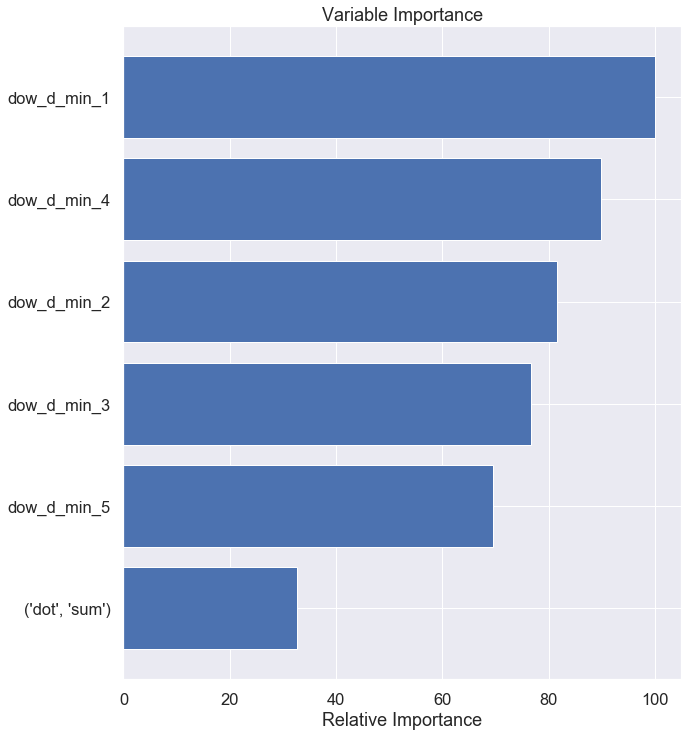

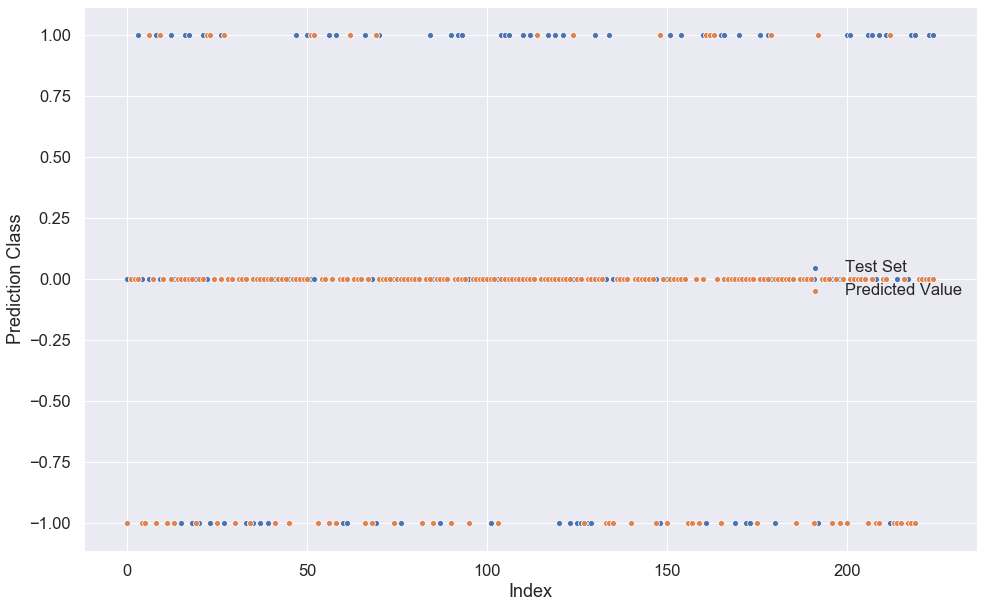

In [487]:

# average model tweet model
## basic model fitting
gtf_train, gtf_test = train_test_split(model_df_filtered, train_size=0.7, random_state=42)

# Split Data into X,Y
X_train, y_train = gtf_train[gtf_train.columns.difference(skip_predictors + trump_predictors)], gtf_train['VIX_change_type']
X_test, y_test = gtf_test[gtf_test.columns.difference(skip_predictors + trump_predictors  )], gtf_test['VIX_change_type']

model = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
acc_trees_training = accuracy_score(y_train, y_pred_train)
acc_trees_testing  = accuracy_score(y_test, y_pred_test)

# These are changing with each fit, plus we want a more validated choice for depth, so do that
print("RF: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("RF: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

print(model.feature_importances_)

# x = np.arange(0,y_test.shape[0],1)
# sns.set(font_scale=1.5)
# sns.lineplot(x ,y_test, label = 'Test Set')
# sns.lineplot(x ,y_pred_test, label = 'Predicted Value')
# plt.xlabel('Index')
# plt.show()

#Top Features
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

pd.crosstab(y_test, model.predict(X_test), margins=True, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(1,1, figsize=(16, 10))
x = np.arange(0,y_test.shape[0],1)
sns.set(font_scale=1.5)
sns.scatterplot(x ,y_test, label = 'Test Set')
sns.scatterplot(x ,y_pred_test, label = 'Predicted Value')
plt.xlabel('Index')
plt.ylabel("Prediction Class")
plt.legend(loc="center right")
plt.show()

RF: Accuracy, Training Set 	 : 97.51%
RF: Accuracy, Testing Set 	 : 50.67%
[0.1193566  0.23663615 0.27791313 0.24205566 0.12403846]


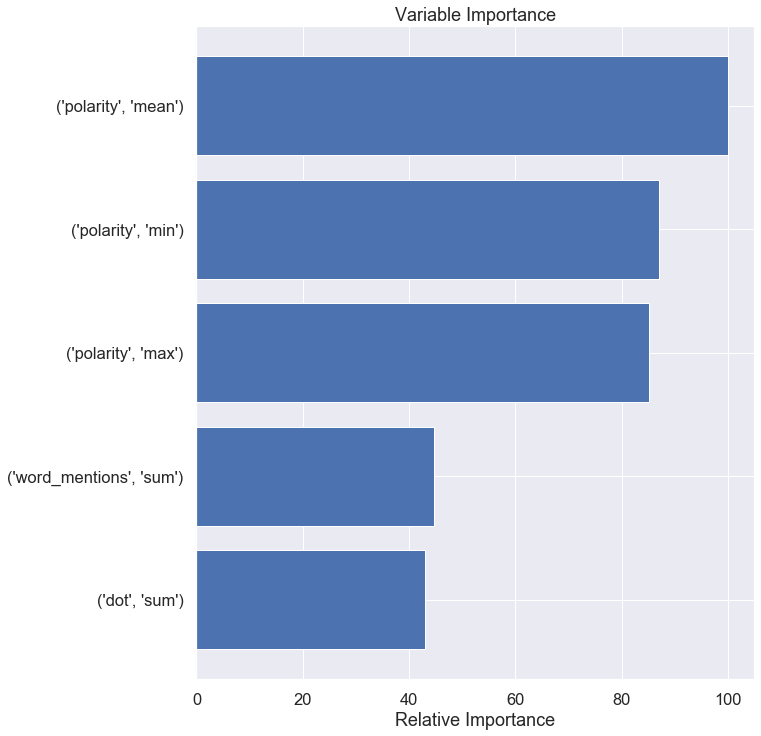

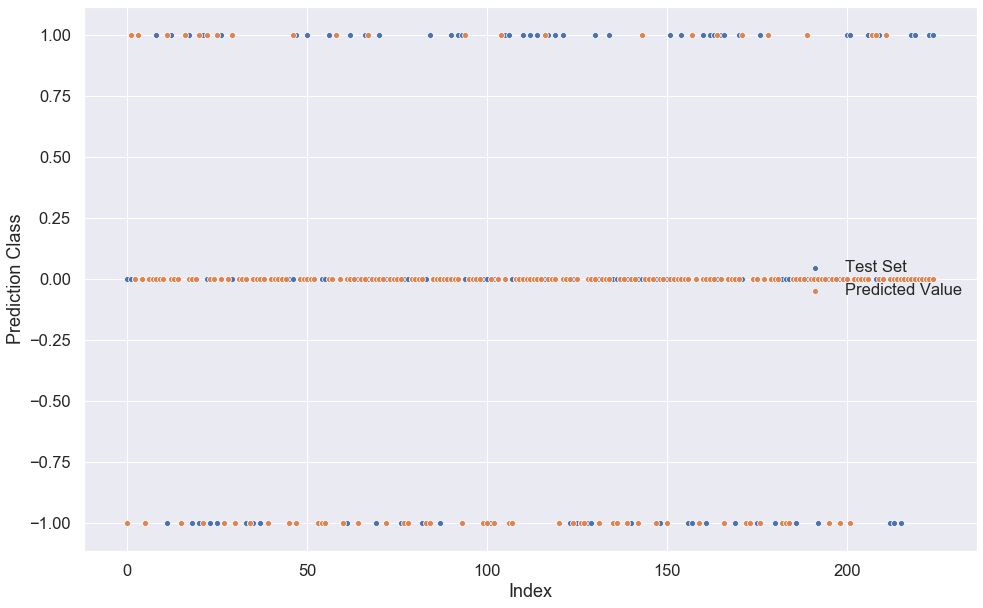

In [489]:

# average model tweet model
## basic model fitting
gtf_train, gtf_test = train_test_split(model_df_filtered, train_size=0.7, random_state=42)

# Split Data into X,Y
X_train, y_train = gtf_train[gtf_train.columns.difference(skip_predictors + dow_predictors)], gtf_train['VIX_change_type']
X_test, y_test = gtf_test[gtf_test.columns.difference(skip_predictors + dow_predictors )], gtf_test['VIX_change_type']

model = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
acc_trees_training = accuracy_score(y_train, y_pred_train)
acc_trees_testing  = accuracy_score(y_test, y_pred_test)

# These are changing with each fit, plus we want a more validated choice for depth, so do that
print("RF: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("RF: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

print(model.feature_importances_)

# x = np.arange(0,y_test.shape[0],1)
# sns.set(font_scale=1.5)
# sns.lineplot(x ,y_test, label = 'Test Set')
# sns.lineplot(x ,y_pred_test, label = 'Predicted Value')
# plt.xlabel('Index')
# plt.show()

#Top Features
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

pd.crosstab(y_test, model.predict(X_test), margins=True, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(1,1, figsize=(16, 10))
x = np.arange(0,y_test.shape[0],1)
sns.set(font_scale=1.5)
sns.scatterplot(x ,y_test, label = 'Test Set')
sns.scatterplot(x ,y_pred_test, label = 'Predicted Value')
plt.xlabel('Index')
plt.ylabel("Prediction Class")
plt.legend(loc="center right")
plt.show()

RF: Accuracy, Training Set 	 : 100.00%
RF: Accuracy, Testing Set 	 : 59.56%
[0.04641448 0.08670836 0.10646705 0.08700444 0.05017201 0.15405403
 0.11805639 0.12177488 0.13180715 0.09754121]


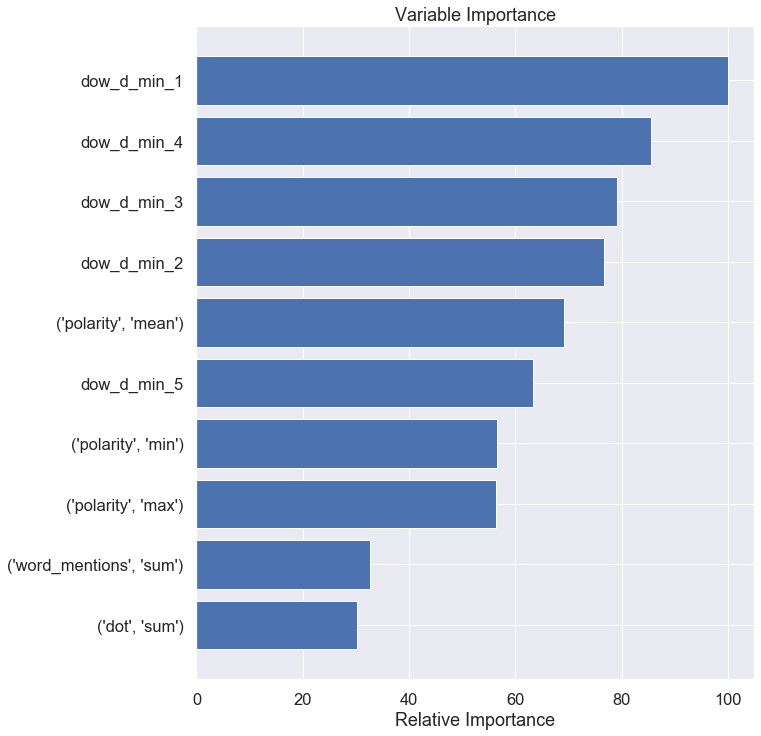

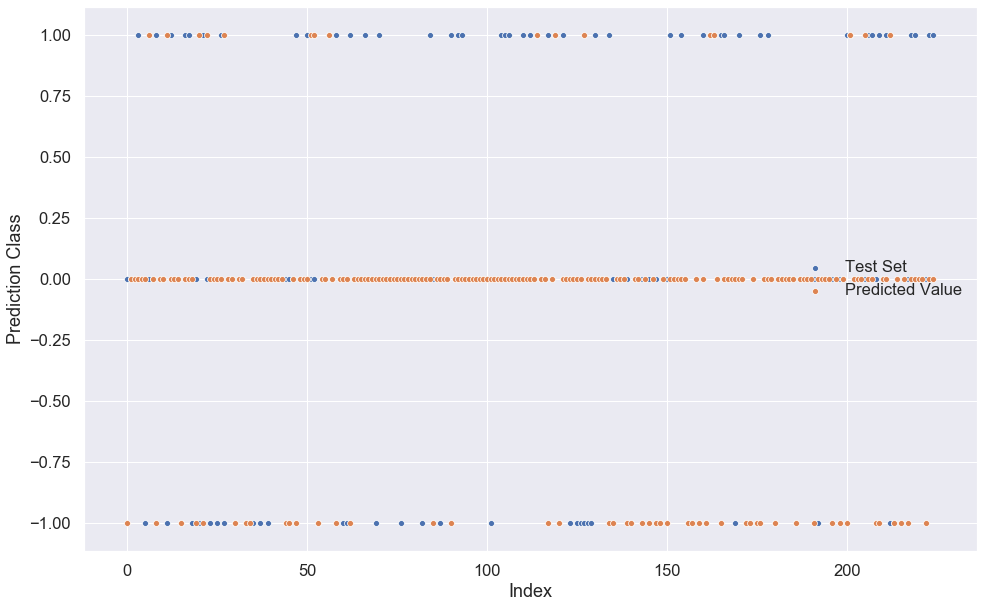

In [486]:

# average model tweet model
## basic model fitting
gtf_train, gtf_test = train_test_split(model_df_filtered, train_size=0.7, random_state=42)

# Split Data into X,Y
X_train, y_train = gtf_train[gtf_train.columns.difference(skip_predictors, aug_ )], gtf_train['VIX_change_type']
X_test, y_test = gtf_test[gtf_test.columns.difference(skip_predictors  )], gtf_test['VIX_change_type']

model = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
acc_trees_training = accuracy_score(y_train, y_pred_train)
acc_trees_testing  = accuracy_score(y_test, y_pred_test)

# These are changing with each fit, plus we want a more validated choice for depth, so do that
print("RF: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("RF: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

print(model.feature_importances_)

# x = np.arange(0,y_test.shape[0],1)
# sns.set(font_scale=1.5)
# sns.lineplot(x ,y_test, label = 'Test Set')
# sns.lineplot(x ,y_pred_test, label = 'Predicted Value')
# plt.xlabel('Index')
# plt.show()

#Top Features
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

pd.crosstab(y_test, model.predict(X_test), margins=True, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(1,1, figsize=(16, 10))
x = np.arange(0,y_test.shape[0],1)
sns.set(font_scale=1.5)
sns.scatterplot(x ,y_test, label = 'Test Set')
sns.scatterplot(x ,y_pred_test, label = 'Predicted Value')
plt.xlabel('Index')
plt.ylabel("Prediction Class")
plt.legend(loc="center right")
plt.show()

### Granular Tweet + DOW